In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1


In [2]:
!pip install keras.rl2 tensorflow==2.3.1

     |████████████████████████████████| 320.4 MB 24 kB/s 
     |████████████████████████████████| 459 kB 47.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.4 MB/s 
     |████████████████████████████████| 2.9 MB 38.9 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
 

In [3]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

# for nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam

In [5]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [6]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
mkdir: cannot create directory ‘rars’: File exists
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_

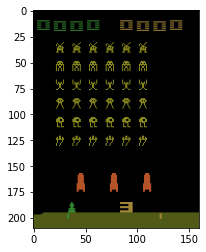

In [7]:
env = gym.make("SpaceInvaders-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(10):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()

In [8]:
episodes=10

for episode in range(1,episodes):
  state=env.reset()
  done=False
  score=0

  while not done:
    env.render()
    state,reward,done,info=env.step(env.action_space.sample())
    score+=reward
  print(episode,score)

1 120.0
2 135.0
3 210.0
4 345.0
5 150.0
6 120.0
7 95.0
8 120.0
9 150.0


BUILDING NN

In [9]:
def build_model(height,width,channels,actions):
  model=Sequential()
  model.add(Conv2D(32,(8,8),strides=(4,4),activation='relu',input_shape=(3,height,width,channels)))
  model.add(Conv2D(63,(4,4), strides=(2,2) ,activation="relu" ))
  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dense(256,activation='relu'))
  model.add(Dense(actions,activation='linear'))
  return model   

In [10]:
height,width,channels=env.observation_space.shape
actions=env.action_space.n

In [16]:
del model

In [17]:
model=build_model(height,width,channels,actions)

In [18]:

from rl.agents import DQNAgent
from rl.memory import SequentialMemory
from rl.policy import LinearAnnealedPolicy,EpsGreedyQPolicy


 

In [19]:
def build_Agent(model,actions):
  policy=LinearAnnealedPolicy(EpsGreedyQPolicy(),attr='eps',value_max=1,value_min=1,value_test=2,nb_steps=10000)
  memory=SequentialMemory(limit=2000,window_length=3)
  dqn=DQNAgent(model=model,memory=memory,policy=policy,enable_dueling_network=True,dueling_type='avg',nb_actions=actions,nb_steps_warmup=1000)
  return dqn
  

In [20]:
dqn=build_Agent(model , actions)

In [21]:
#it will take some time for this process to done
dqn.compile(Adam(lr=0.001))
dqn.fit(env,nb_steps=4000,visualize=True,verbose=1)

Training for 4000 steps ...
Interval 1 (0 steps performed)
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
 4000/10000 [===========>..................] - ETA: 54:32 - reward: 0.2100done, took 2181.814 seconds


In [22]:
scores=dqn.test(env,nb_episodes=10,visualize=True)

Testing for 10 episodes ...
Episode 1: reward: 365.000, steps: 738
Episode 2: reward: 140.000, steps: 686
Episode 3: reward: 35.000, steps: 644
Episode 4: reward: 60.000, steps: 721
Episode 5: reward: 35.000, steps: 511
Episode 6: reward: 50.000, steps: 536
Episode 7: reward: 85.000, steps: 821
Episode 8: reward: 95.000, steps: 700
Episode 9: reward: 60.000, steps: 539
Episode 10: reward: 130.000, steps: 1049


In [23]:
dqn.save_weights('dqn.h5f')